In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import joblib

In [6]:
# Load data
X_train = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/X_train.parquet")
X_test = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/X_test.parquet")
X_val = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/X_val.parquet")
y_train = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/y_train.parquet").squeeze()
y_test = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/y_test.parquet").squeeze()
y_val = pd.read_parquet("https://github.com/monatagelsir7/enivornmental_impact_of_aviation/raw/refs/heads/main/Test-Train-Validation%20Data/y_val.parquet").squeeze()

In [ ]:
# Select features and encode
features = ["acft_class", "WB", "NB", "RJ", "TP", "PP", "PJ", "seats", "n_flights"]
X_train = pd.get_dummies(df_train[features])
X_test = pd.get_dummies(df_test[features])
y_train = df_train["co2_per_km"]
y_test = df_test["co2_per_km"]

In [7]:
# Baseline Model
base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
base_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [8]:
# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Grid Search Setup
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed")

# Best Model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nBest Parameters: {best_params}")

Starting grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  39.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  40.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_

/Users/yirang/miniforge3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 4.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=None,

In [9]:
# Evaluation Function
def evaluate_model(model, X, y, set_name):
    pred = model.predict(X)
    metrics = {
        'R²': r2_score(y, pred),
        'RMSE': np.sqrt(mean_squared_error(y, pred)),
        'MAE': mean_absolute_error(y, pred)
    }
    print(f"\n{set_name} Performance:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    return metrics

# Compare Performance
print("\n=== Baseline Model ===")
base_metrics_val = evaluate_model(base_model, X_val, y_val, 'Validation')
base_metrics_test = evaluate_model(base_model, X_test, y_test, 'Test')

print("\n=== Tuned Model ===")
tuned_metrics_val = evaluate_model(best_model, X_val, y_val, 'Validation')
tuned_metrics_test = evaluate_model(best_model, X_test, y_test, 'Test')


=== Baseline Model ===

Validation Performance:
R²: 0.9859
RMSE: 883.0435
MAE: 46.3717

Test Performance:
R²: 0.9850
RMSE: 961.7582
MAE: 50.0476

=== Tuned Model ===

Validation Performance:
R²: 0.9242
RMSE: 2048.2105
MAE: 181.0479

Test Performance:
R²: 0.9235
RMSE: 2169.8373
MAE: 192.7441


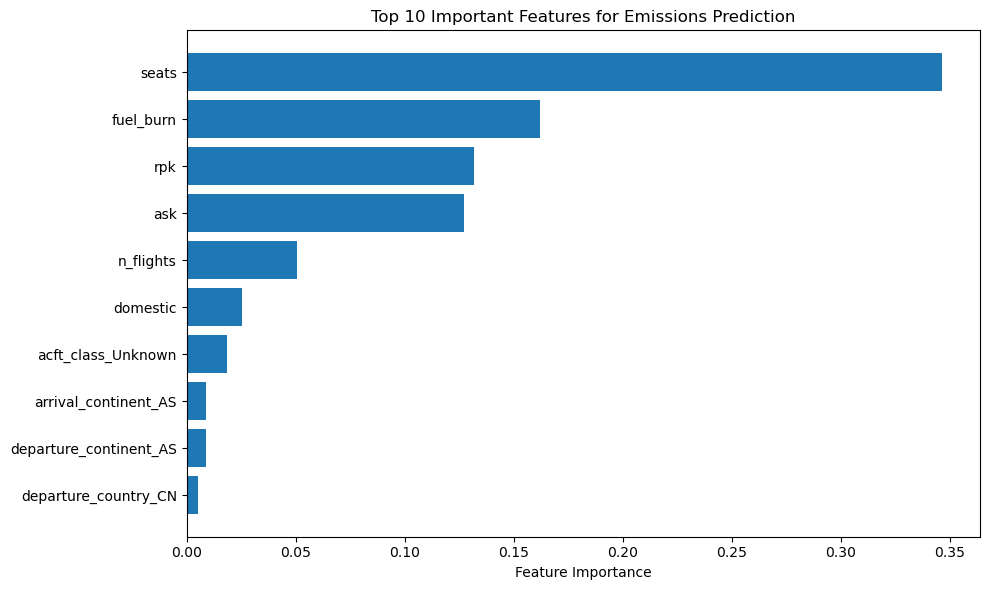


Best model and features saved


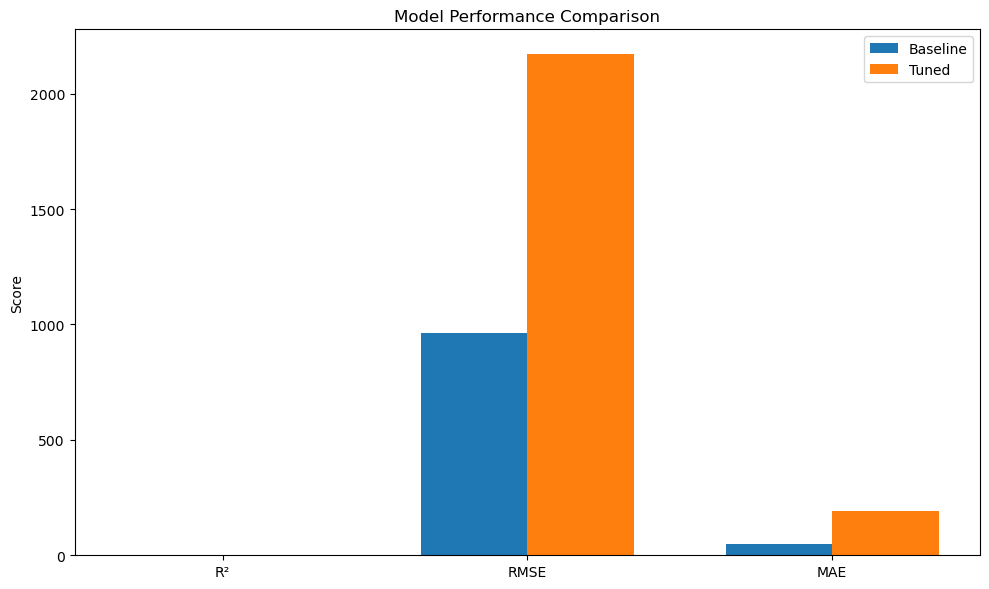

In [10]:
# Feature Importance Visualization
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features for Emissions Prediction")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Save Best Model
joblib.dump(best_model, "tuned_rf_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")
print("\nBest model and features saved")

# Performance Comparison Plot
metrics = ['R²', 'RMSE', 'MAE']
baseline_values = [base_metrics_test[m] for m in metrics]
tuned_values = [tuned_metrics_test[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_values, width, label='Baseline')
plt.bar(x + width/2, tuned_values, width, label='Tuned')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.savefig('performance_comparison.png')
plt.show()